In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"comptelol","key":"e63d845fa8d1890f86a51fa2a6547bfd"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d marcozuppelli/stegoimagesdataset


Dataset URL: https://www.kaggle.com/datasets/marcozuppelli/stegoimagesdataset
License(s): DbCL-1.0


In [5]:
!unzip stegoimagesdataset.zip -d stegoimagesdataset


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: stegoimagesdataset/val/val/stego/image_06334_ps_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06334_ps_1.png  
  inflating: stegoimagesdataset/val/val/stego/image_06335_eth_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06335_html_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06335_url_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06336_html_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06336_html_1.png  
  inflating: stegoimagesdataset/val/val/stego/image_06336_url_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06337_html_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06337_js_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06337_url_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06338_eth_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06338_js_0.png  
  inflating:

In [6]:
import os
from PIL import Image

def convert_clean_rgba_to_rgb(root_dirs):
    """
    Parcourt uniquement les sous-dossiers 'clean' de chacun des répertoires racines
    et convertit les images PNG RGBA en RGB.
    """
    for root in root_dirs:
        clean_dir = os.path.join(root, 'clean')
        if not os.path.isdir(clean_dir):
            continue

        for fname in os.listdir(clean_dir):
            if not fname.lower().endswith('.png'):
                continue

            path = os.path.join(clean_dir, fname)
            try:
                with Image.open(path) as img:
                    if img.mode == 'RGBA':
                        rgb_img = img.convert('RGB')
                        rgb_img.save(path)
                        print(f"Converted RGBA → RGB: {path}")
            except Exception as e:
                print(f"Error processing {path}: {e}")

# Exemple d'utilisation :
train_dir = 'stegoimagesdataset/train/train'
val_dir   = 'stegoimagesdataset/val/val'
test_dir  = 'stegoimagesdataset/test/test'

convert_clean_rgba_to_rgb([train_dir, val_dir, test_dir])


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/00643.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/03475.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/02347.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/01268.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/03652.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/02022.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/02408.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/01956.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/00507.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/02400.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/03157.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/00290.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/00184.png
Converted RGBA → RGB: ste

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models


class CustomCNNFusion(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 32, 224, 224]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 32, 112, 112]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 64, 56, 56]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 128, 28, 28]
        )

        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Linear(128 * 28 * 28 + 8, 128),  # +8 pour les features statistiques
            nn.ReLU(),
            nn.Linear(128, 2)  # 2 classes : normal / steg
        )

    def forward(self, x_img, x_stats):
        x = self.cnn(x_img)
        x = self.flatten(x)              # [B, 128 * 28 * 28]
        x = torch.cat((x, x_stats), dim=1)  # fusion avec features stats
        return self.fc(x)




class ResStatFusion(nn.Module):
    def __init__(self):
        super().__init__()

        base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(base_model.children())[:-1])  # form of the tensor just after the last layer :
        #[B, 512, 1, 1], Remove the last fully connected layer and keep the pipeline which extracts features
        # from the image. The last layer is a fully connected layer that outputs 1000 classes (ImageNet).
        """
        Why 512 ? :
        ResNet18 has 512 channels(features maps, filters) in the last convolutional layer before the fully connected layer.
        Each convolutional filter in the last layer yields a feature map, and the number of filters in the last layer is 512.
        The output of the last convolutional layer is a tensor with shape [B, 512, 1, 1], where B is the batch size.
        The 1x1 spatial dimension indicates that the feature maps have been pooled down to a single value per channel.
        The AvgPool2d layer reduces(computes the average of the pixels in the image) the spatial dimensions to 1x1, effectively summarizing each feature map into a single value.
        So in the end, we get a tensor of shape [B, 512] after the squeeze operation.

        """


        self.stat_fc = nn.Sequential( #pipeline for the statistical features
            nn.Linear(8, 64), # [B, 8] -> [B, 64] : output = input * weight + bias
            nn.ReLU(), # activation function : f(x) = max(0, x)
            nn.Linear(64, 64),
            nn.ReLU()
        )

        # fusion layer
        self.final_fc = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, image, stat_feats):
        # CNN branch
        cnn_feat = self.cnn(image).squeeze()  # [B, 512], we dont need 1x1 spatial dimension, so we remove it with squeeze()
        if cnn_feat.dim() == 1: # If the batch size is 1, add a dimension to make it [1, 512]
            cnn_feat = cnn_feat.unsqueeze(0)

        # MLP branch
        stat_feat = self.stat_fc(stat_feats)  # [B, 64], passing the statistical features through the MLP

        fusion = torch.cat((cnn_feat, stat_feat), dim=1)  # [B, 576], concatenate the two branches
        out = self.final_fc(fusion) # [B, 2], passing through the final fully connected layer
        return out




In [8]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from scipy.stats import kurtosis, skew
from torchvision import transforms
import warnings

class FusionFeatureDataset(Dataset):
    def __init__(self, root_dir, transform=None, device=None):
        self.device = device
        self.images = []
        self.stat_features = []
        self.labels = []

        for label_name in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label_name)
            label = 0 if label_name.lower() == 'clean' else 1

            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                img = Image.open(img_path)

                stat_feat = self.extract_stat_features(img)

                img_t = transform(img).to(self.device)
                stat_t = stat_feat.to(self.device)
                lbl_t  = torch.tensor(label, dtype=torch.long, device=self.device)

                self.images.append(img_t)
                self.stat_features.append(stat_t)
                self.labels.append(lbl_t)

        torch.cuda.empty_cache()
        self.images = torch.stack(self.images)
        self.stat_features = torch.stack(self.stat_features)
        self.labels = torch.stack(self.labels)

    def extract_stat_features(self, img):
        """
        Extracts 8 statistical features from a grayscale image.
        """
        img_gray = img.convert('L')
        data = np.asarray(img_gray).astype(np.float32).flatten()
        data = np.clip(data, 1e-5, 255)
        eps = 1e-5

        try:
            std = np.std(data)
            range_val = np.max(data) - np.min(data)
            median = np.median(data)
            geo_median = np.exp(np.mean(np.log(data + eps)))  # safe log
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                skewness = skew(data)
                kurt = kurtosis(data)

            d1 = np.diff(data)
            d2 = np.diff(d1)

            var0 = np.var(data) + eps
            var1 = np.var(d1) + eps
            var2 = np.var(d2) + eps

            mobility = np.sqrt(var1 / var0)

            raw_complexity = (var2 / var1) - (var1 / var0)
            raw_complexity = np.maximum(raw_complexity, 0)
            complexity = np.sqrt(raw_complexity)

            features = np.array([std, range_val, median, geo_median, skewness, kurt, mobility, complexity], dtype=np.float32)
            features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

            return torch.tensor(features, dtype=torch.float32)

        except Exception as e:
            print("Erreur lors de l'extraction des features statistiques :", e)
            return torch.zeros(8, dtype=torch.float32)

    def __getitem__(self, index):
        # Simply return the preloaded images and stats
        return self.images[index], self.stat_features[index], self.labels[index]

    def __len__(self):
        return len(self.images)



In [9]:
import random
from torchvision import transforms
import torchvision.transforms.functional as TF

class RandomRotation:
    def __call__(self, img):
        angles = [0, 90, 180, 270]
        angle = random.choice(angles)
        return TF.rotate(img, angle)


transform = transforms.Compose([
    #RandomRotation(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dir = 'stegoimagesdataset/train/train/'
val_dir = 'stegoimagesdataset/val/val/'
test_dir = 'stegoimagesdataset/test/test/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_dataset = FusionFeatureDataset(root_dir=train_dir, transform=transform, device=device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = FusionFeatureDataset(root_dir=val_dir, transform=transform, device=device)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

#test_dataset = FusionFeatureDataset(root_dir=test_dir, transform=transform, device=device)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Exemple de batch :
for img_batch, stat_batch, label_batch in train_loader:
    print(img_batch.shape)       # [32, 3, 224, 224]
    print(stat_batch.shape)      # [32, 8]
    print(label_batch.shape)     # [32]
    break

Using device: cuda
torch.Size([32, 3, 224, 224])
torch.Size([32, 8])
torch.Size([32])


In [12]:
import time
from torch.amp import autocast, GradScaler

class_counts = [4000, 12000]
total = sum(class_counts)
class_weights = [total / c for c in class_counts]  # inverse fréquence

weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

def train_model(model, train_loader, val_loader, num_epochs, device, patience, save_path):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_acc = 0.0
    epochs_without_improvement = 0

    scaler = GradScaler()
    print(f"Starting training for model: {model.__class__.__name__} at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())} for {num_epochs} epochs")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, stat_feats, labels in train_loader:
            images, stat_feats, labels = images.to(device), stat_feats.to(device), labels.to(device)

            optimizer.zero_grad()
            #with autocast(device_type='cuda'):
            outputs = model(images, stat_feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #scaler.scale(loss).backward()
            #scaler.step(optimizer)
            #scaler.update()

            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total * 100
        print(f"[Train] Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss} | Accuracy: {epoch_acc:.2f}%")

        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_feats, val_labels in val_loader:
                val_images, val_feats, val_labels = val_images.to(device), val_feats.to(device), val_labels.to(device)
                val_outputs = model(val_images, val_feats)
                _, val_pred = torch.max(val_outputs, 1)
                val_correct += (val_pred == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_acc = val_correct / val_total * 100
        print(f"[Validation] Accuracy: {val_acc:.2f}%")

        # === Early Stopping & Best Model Saving ===
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
            print("Best model saved.")
        else:
            epochs_without_improvement += 1
            print(f"No improvement. ({epochs_without_improvement}/{patience})")

        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    print(f"Training finished. Best Validation Accuracy: {best_val_acc:.2f}%")
    return model


In [13]:
model = CustomCNNFusion()
model2 = ResStatFusion()
trained_model = train_model(model, train_loader, val_loader, num_epochs=100, device=device, patience=15, save_path='best_model_CNNFUSION.pth')
trained_model2 = train_model(model2, train_loader, val_loader, num_epochs=100, device=device, patience=15, save_path='best_model_ResStatFusion.pth')

Starting training for model: CustomCNNFusion at 2025-04-25 16:30:01 for 100 epochs
[Train] Epoch 1/100 | Loss: 0.6961173300743103 | Accuracy: 54.35%
[Validation] Accuracy: 25.09%
Best model saved.
[Train] Epoch 2/100 | Loss: 0.6940044449567795 | Accuracy: 57.20%
[Validation] Accuracy: 32.88%
Best model saved.
[Train] Epoch 3/100 | Loss: 0.6936673147678375 | Accuracy: 55.56%
[Validation] Accuracy: 34.23%
Best model saved.
[Train] Epoch 4/100 | Loss: 0.6939341475963593 | Accuracy: 55.81%
[Validation] Accuracy: 56.69%
Best model saved.
[Train] Epoch 5/100 | Loss: 0.6926724636554717 | Accuracy: 54.16%
[Validation] Accuracy: 71.09%
Best model saved.
[Train] Epoch 6/100 | Loss: 0.6922269982099533 | Accuracy: 59.91%
[Validation] Accuracy: 74.85%
Best model saved.
[Train] Epoch 7/100 | Loss: 0.6920452877283096 | Accuracy: 58.49%
[Validation] Accuracy: 74.44%
No improvement. (1/15)
[Train] Epoch 8/100 | Loss: 0.693069817185402 | Accuracy: 57.23%
[Validation] Accuracy: 74.16%
No improvement. (2/

In [14]:
import shutil
import os

# Chemin de base
base_path = 'stegoimagesdataset/test/test/'

# Dossiers à supprimer
folders_to_delete = ['stego_b64', 'stego_zip']

# Suppression des dossiers
for folder in folders_to_delete:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Dossier supprimé : {folder_path}")
    else:
        print(f"Dossier non trouvé : {folder_path}")


Dossier supprimé : stegoimagesdataset/test/test/stego_b64
Dossier supprimé : stegoimagesdataset/test/test/stego_zip


In [16]:
test_dataset = FusionFeatureDataset(root_dir=test_dir, transform=transform, device="cpu")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

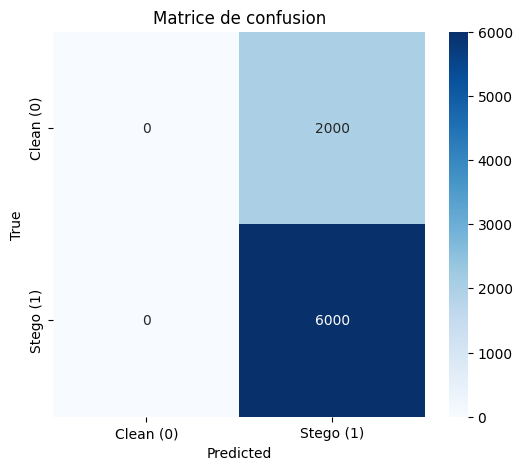

Rapport de classification :
              precision    recall  f1-score   support

   Clean (0)       0.00      0.00      0.00      2000
   Stego (1)       0.75      1.00      0.86      6000

    accuracy                           0.75      8000
   macro avg       0.38      0.50      0.43      8000
weighted avg       0.56      0.75      0.64      8000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


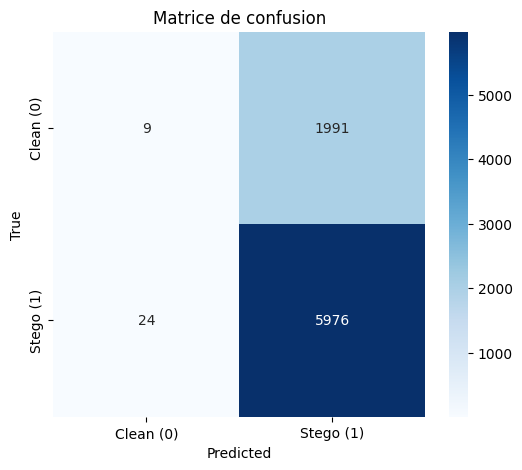

Rapport de classification :
              precision    recall  f1-score   support

   Clean (0)       0.27      0.00      0.01      2000
   Stego (1)       0.75      1.00      0.86      6000

    accuracy                           0.75      8000
   macro avg       0.51      0.50      0.43      8000
weighted avg       0.63      0.75      0.64      8000



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def test_model(model_class, test_loader, model_path, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, stat_feats, labels in test_loader:
            images, stat_feats, labels = images.to(device), stat_feats.to(device), labels.to(device)
            outputs = model(images, stat_feats)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    labels_names = ['Clean (0)', 'Stego (1)']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_names, yticklabels=labels_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Matrice de confusion')
    plt.show()

    print("Rapport de classification :")
    print(classification_report(y_true, y_pred, target_names=labels_names))

test_model(CustomCNNFusion, test_loader, 'best_model_CNNFUSION.pth', device)
test_model(ResStatFusion, test_loader, 'best_model_ResStatFusion.pth', device)

### Résultats

- déséquilibre dans les prédictions
- le modèle prévoit presque uniquement la classe stego, il a une bonne accuracy globale parce que 6000/8000 images sont stégo
- il échoue complétement à détecter les images clean

training ? 
- vu que 4k clean vs 12k stego, le modèle shortcut, il se contente de prédire stégo, il atteint 75% d'accuracy
- il faudrait pénaliser davantage les erreurs sur la classe clean (minoritaire)

Est ce que les clean sont très proche visuellement des stégo ???